In [1]:
try:
    import torch as t
    import torch.nn as tnn
except ImportError:
    print("Colab users: pytorch comes preinstalled. Select Change Ru")
    print("Local users: Please install pytorch for your hardware using instructions from here: https://pytorch.org/get-started/locally/")
    print("ACG users: Please follow instructions here: https://vikasdhiman.info/ECE490-Neural-Networks/posts/0000-00-06-acg-slurm-jupyter/")
    
    raise

In [2]:
def wget(url, filename):
    """
    Download files using requests package. 
    Better than wget command line because this is cross platform.
    """
    try:
        import requests
    except ImportError:
        import subprocess
        subprocess.call("pip install requests".split())
        import requests
    r = requests.get(url)
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content():
            fd.write(chunk)

In [3]:
## Doing it the Pytorch way without using our custom feature extraction
DEVICE='cuda:0'
DTYPE=t.float32
import torch
import torch.nn
import torch.optim
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

torch.manual_seed(17)

# Getting the dataset, the Pytorch way
all_training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
training_data, validation_data = torch.utils.data.random_split(all_training_data, [0.9, 0.1])

In [8]:
# Hyper parameters
learning_rate = 1e-3 # controls how fast the 
batch_size = 64
epochs = 5
momentum = 0.9

training_dataloader = DataLoader(training_data, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data,  batch_size=batch_size)
test_dataloader = DataLoader(test_data,  batch_size=batch_size)


loss = torch.nn.CrossEntropyLoss()

# TODO:
# Define model = ?
class MLPNetwork(torch.nn.Module):
    def __init__(self, hidden_size=10, nclasses=10, input_size=28*28):
        super().__init__()
        self._layers = torch.nn.ModuleList([torch.nn.Flatten(),
            tnn.Linear(input_size, hidden_size),
            tnn.ReLU(),
            tnn.Linear(hidden_size, nclasses)])
    def forward(self, x):
        for l in self._layers:
            xnext = l(x) # call the layers in sequence
            x = xnext
        return x
model = MLPNetwork()

# alternatively you can also
# hidden_size=10
# nclasses=10
# input_size=28*28
# model = torch.nn.Sequential(torch.nn.Flatten(),
#            tnn.Linear(input_size, hidden_size),
#            tnn.ReLU(),
#            tnn.Linear(hidden_size, nclasses))
# 

# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

def loss_and_accuracy(model, loss, validation_dataloader, device=DEVICE):
    # Validation loop
    validation_size = len(validation_dataloader.dataset)
    num_batches = len(validation_dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in validation_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss(pred, y).item()
            correct += (pred.argmax(dim=-1) == y).type(DTYPE).sum().item()

    test_loss /= num_batches
    correct /= validation_size
    return test_loss, correct
    
def train(model, loss, training_dataloader, validation_dataloader, device=DEVICE):
    model.to(device)
    train_losses = []
    valid_losses = []
    for t in range(epochs):
        # Train loop
        training_size = len(training_dataloader.dataset)
        for batch, (X, y) in enumerate(training_dataloader):
            X = X.to(device)
            y = y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss_t = loss(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss_t, current = loss_t.item(), (batch + 1) * len(X)
                print(f"loss: {loss_t:>7f}  [{current:>5d}/{training_size:>5d}]", end="\r")
                train_losses.append(loss_t)
                valid_loss, correct = loss_and_accuracy(model, loss, validation_dataloader, device=device)
                valid_losses.append(valid_loss)
                print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    return model, train_losses, valid_losses
        
trained_model, train_losses, valid_losses = train(model, loss, training_dataloader, validation_dataloader)

test_loss, correct = loss_and_accuracy(model, loss, test_dataloader)
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Validation Error:   64/54000]
 Accuracy: 10.9%, Avg loss: 2.325170 

Validation Error: 6464/54000]
 Accuracy: 13.6%, Avg loss: 2.183869 

Validation Error: 2864/54000]
 Accuracy: 34.1%, Avg loss: 2.001862 

Validation Error: 9264/54000]
 Accuracy: 46.8%, Avg loss: 1.787784 

Validation Error: 5664/54000]
 Accuracy: 54.8%, Avg loss: 1.580385 

Validation Error: 2064/54000]
 Accuracy: 62.2%, Avg loss: 1.389772 

Validation Error: 8464/54000]
 Accuracy: 68.5%, Avg loss: 1.216087 

Validation Error: 4864/54000]
 Accuracy: 75.8%, Avg loss: 1.061541 

Validation Error: 1264/54000]
 Accuracy: 79.9%, Avg loss: 0.935546 

Validation Error:   64/54000]
 Accuracy: 80.2%, Avg loss: 0.889401 

Validation Error: 6464/54000]
 Accuracy: 82.1%, Avg loss: 0.803695 

Validation Error: 2864/54000]
 Accuracy: 82.9%, Avg loss: 0.736784 

Validation Error: 9264/54000]
 Accuracy: 83.7%, Avg loss: 0.682686 

Validation Error: 5664/54000]
 Accuracy: 84.5%, Avg loss: 0.639954 

Validation Error: 2064/54000]
 Acc

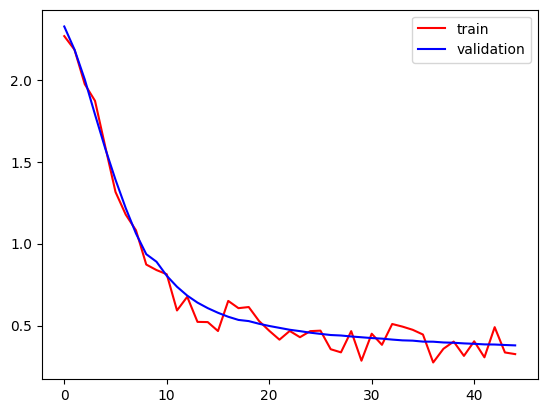

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_losses, 'r', label='train')
plt.plot(valid_losses, 'b', label='validation')
plt.legend()

In [11]:
torch.nn.__file__

'/home/vdhiman/.local/share/virtualenvs/nbgrader-notebooks-_16a_jDm/lib/python3.10/site-packages/torch/nn/__init__.py'

In [12]:
X, _ = next(iter(test_dataloader))
X.shape

torch.Size([64, 1, 28, 28])

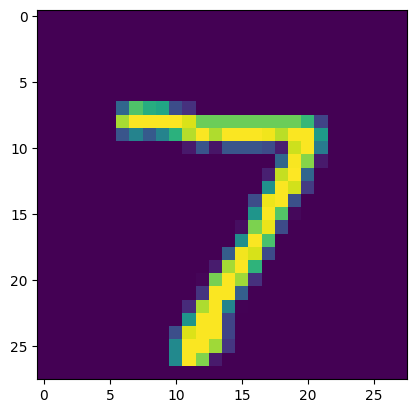

In [13]:
import matplotlib.pyplot as plt
plt.imshow(X[0, 0])

In [14]:
print("The predicted image label is ", model(X.to(DEVICE)).argmax(dim=-1)[0].item())

The predicted image label is  7
